In [1]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.set_index('OSEBuildingID', inplace = True)

In [4]:
data

,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),EnergyStarNaN,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Age,PropertyGFAParking(%),PropertyGFABuilding(s)(%),SteamUse(%),Electricity(%),NaturalGas(%),PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,12,88434,88434.0,60.0,81.699997,84.300003,182.500000,189.000000,0,7.226362e+06,7.456910e+06,249.98,2.83,89,0.000000,100.000000,27.730162,54.605993,17.663838,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1.0,11,103566,83880.0,61.0,94.800003,97.900002,176.100006,179.399994,0,8.387933e+06,8.664479e+06,295.86,2.86,20,14.545314,85.454686,0.000000,38.660907,61.339093,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1.0,41,956110,756493.0,43.0,96.000000,97.699997,241.899994,244.100006,0,7.258702e+07,7.393711e+07,2089.28,2.19,47,20.574829,79.425171,29.711308,68.230741,2.057944,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,1.0,10,61320,61320.0,56.0,110.800003,113.300003,216.199997,224.000000,0,6.794584e+06,6.946800e+06,286.43,4.67,90,0.000000,100.000000,32.591344,40.751928,26.656717,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,1.0,18,175580,123445.0,75.0,114.800003,118.699997,211.399994,215.600006,0,1.417261e+07,1.465650e+07,505.01,2.88,36,35.311539,64.688461,0.000000,37.880168,62.119825,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50222,1.0,1,12294,12294.0,46.0,69.099998,76.699997,161.699997,176.100006,0,8.497457e+05,9.430032e+05,20.94,1.70,26,0.000000,100.000000,0.000000,61.697384,38.302639,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
50223,1.0,1,16000,16000.0,0.0,59.400002,65.900002,114.199997,118.900002,1,9.502762e+05,1.053706e+06,32.17,2.01,12,0.000000,100.000000,0.000000,41.729558,58.270426,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
50224,1.0,1,13157,7583.0,0.0,438.200012,460.100006,744.799988,767.799988,1,5.765898e+06,6.053764e+06,223.54,16.99,42,0.000000,100.000000,0.000000,31.082041,68.917956,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
data.loc[data['SourceEUI(kBtu/sf)'].isnull()]

,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),EnergyStarNaN,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Age,PropertyGFAParking(%),PropertyGFABuilding(s)(%),SteamUse(%),Electricity(%),NaturalGas(%),PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
773,1.0,4,63150,63150.0,0.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,92,0.0,100.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
26532,1.0,2,20760,20760.0,0.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,88,0.0,100.0,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [6]:
data.loc[data['TotalGHGEmissions'].isnull(), 'TotalGHGEmissions'] = np.mean(data['TotalGHGEmissions'])

In [7]:
data.loc[data['GHGEmissionsIntensity'].isnull(), 'GHGEmissionsIntensity'] = np.mean(data['GHGEmissionsIntensity'])

In [8]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [9]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','EnergyStarNaN',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]


y = data['TotalGHGEmissions']

In [10]:
X.head()

,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking(%),PropertyGFABuilding(s)(%),LargestPropertyUseTypeGFA,ENERGYSTARScore,EnergyStarNaN,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,89,1.0,12,88434,0.000000,100.000000,88434.0,60.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,20,1.0,11,103566,14.545314,85.454686,83880.0,61.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,47,1.0,41,956110,20.574829,79.425171,756493.0,43.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,90,1.0,10,61320,0.000000,100.000000,61320.0,56.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,36,1.0,18,175580,35.311539,64.688461,123445.0,75.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [11]:
y.head()

OSEBuildingID
1     249.98
2     295.86
3    2089.28
5     286.43
8     505.01
Name: TotalGHGEmissions, dtype: float64

In [12]:
"""std_scale = StandardScaler().fit(X)
X_scale = std_scale.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state = 17)"""

'std_scale = StandardScaler().fit(X)\nX_scale = std_scale.transform(X)\nX_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state = 17)'

In [13]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=10_000, noise=100, random_state=0)
y = np.expm1((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

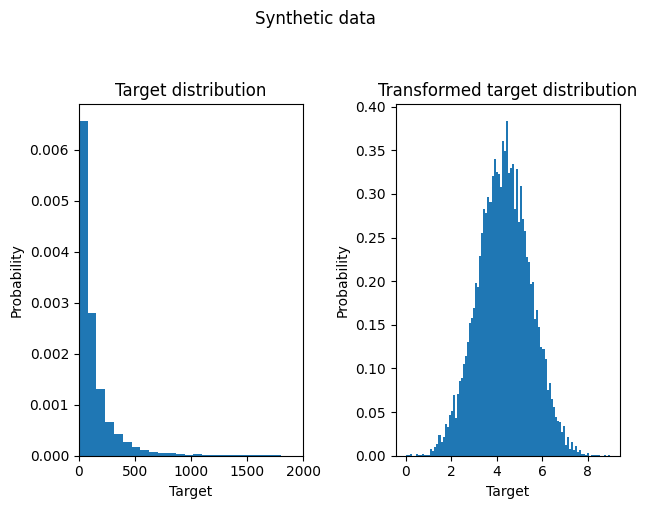

In [61]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_xlim([0, 2000])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=0)

In [15]:
X_test.shape

(2000, 100)

In [62]:
dr = DummyRegressor(strategy="mean")

In [63]:
dr.fit(X_train, y_train)

DummyRegressor()

In [64]:
dr.score(X_test, y_test)

-6.249062651808579e-05

In [65]:
baseline_error = mean_squared_error(y_test, dr.predict(y_test), squared=False)

In [66]:
baseline_error

1.1639246843852058

In [67]:
lr = LinearRegression()

In [68]:
lr.fit(X_train, y_train)

LinearRegression()

In [69]:
mean_squared_error(y_test, lr.predict(X_test), squared=False)

0.5160758629803817

In [70]:
n_alphas = 100
alphas = np.logspace(-1, 7, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, mean_squared_error(y_test, ridge.predict(X_test), squared=False)])

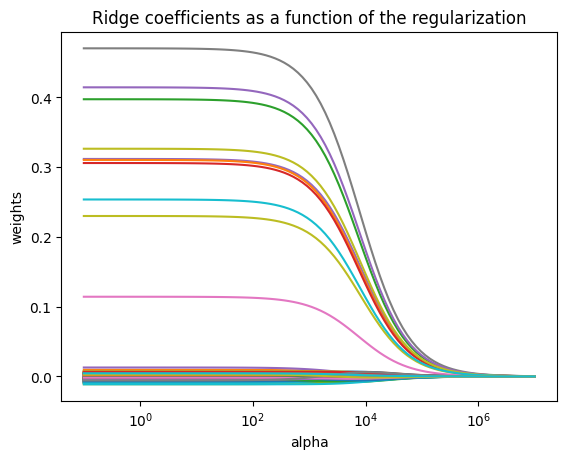

In [71]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

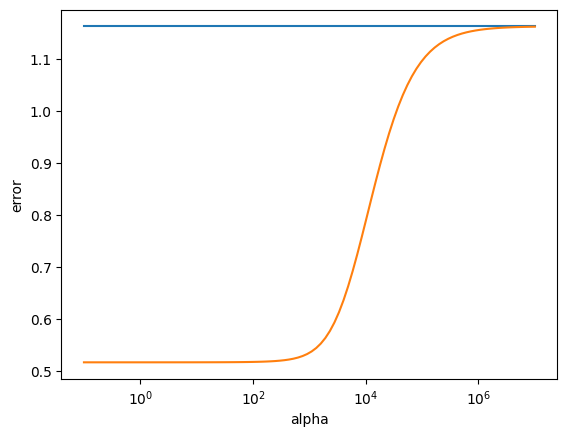

In [72]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [73]:
np.min(errors)

0.5160764876479093

In [74]:
errors.index(min(errors))

0

In [75]:
errors[errors.index(min(errors))]

[1.1639246843852058, 0.5160764876479093]

In [76]:
alphas[errors.index(min(errors))]

0.1

In [77]:
ridge.set_params(alpha = alphas[errors.index(min(errors))])
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [78]:
mean_squared_error(y_test, ridge.predict(X_test), squared=False)

0.5160764876479093

In [81]:
n_alphas = 100
alphas = np.logspace(-1, 0, n_alphas)
lasso = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])

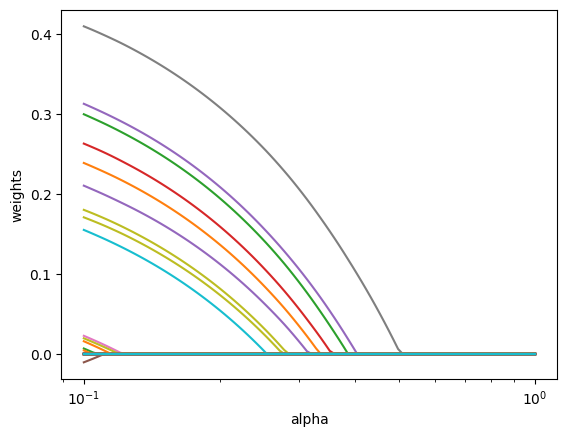

In [82]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

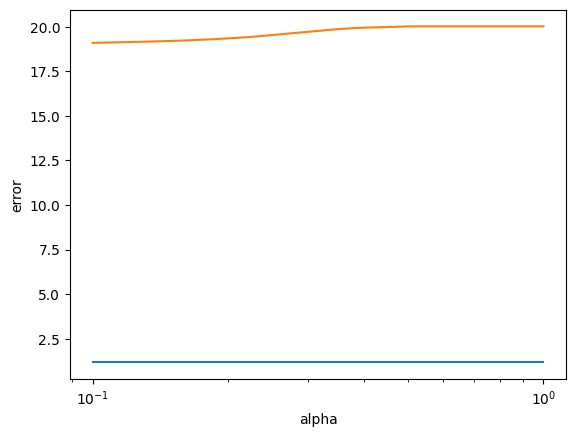

In [83]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [84]:
np.min(errors)

1.1639246843852058

In [85]:
errors.index(min(errors))

0

In [86]:
alphas[errors.index(min(errors))]

0.1

In [87]:
lasso.set_params(alpha = alphas[errors.index(min(errors))])
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, fit_intercept=False)

In [88]:
mean_squared_error(y_test, lasso.predict(X_test), squared=False)

4.370925368751725

In [89]:
params = {'alpha': np.logspace(0, 7, 150)}

In [90]:
grid = GridSearchCV(Ridge(), params, cv = 10)

In [91]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e+00, 1.11424288e+00, 1.24153719e+00, 1.38337396e+00,
       1.54141458e+00, 1.71751022e+00, 1.91372352e+00, 2.13235280e+00,
       2.37595891e+00, 2.64739529e+00, 2.94984134e+00, 3.28683970e+00,
       3.66233771e+00, 4.08073370e+00, 4.54692846e+00, 5.06638264e+00,
       5.64518076e+00, 6.29010244e+00, 7.00870182e+00, 7...
       6.69118990e+05, 7.45561067e+05, 8.30736107e+05, 9.25641789e+05,
       1.03138977e+06, 1.14921870e+06, 1.28050875e+06, 1.42679775e+06,
       1.58979923e+06, 1.77142246e+06, 1.97379486e+06, 2.19928686e+06,
       2.45053971e+06, 2.73049642e+06, 3.04243618e+06, 3.39001283e+06,
       3.77729765e+06, 4.20882699e+06, 4.68965549e+06, 5.22541521e+06,
       5.82238167e+06, 6.48754729e+06, 7.22870335e+06, 8.05453121e+06,
       8.97470401e+06, 1.00000000e+07])})

In [92]:
best_params = grid.best_params_
best_params

{'alpha': 20.67455838273132}

In [94]:
res = pd.DataFrame(grid.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008329,0.005637,0.002730,0.007089,1.0,{'alpha': 1.0},0.808202,0.794787,0.815357,0.799370,0.783699,0.794580,0.823806,0.804468,0.828882,0.831454,0.808461,0.015232,35
1,0.006733,0.001545,0.000351,0.000019,1.114243,{'alpha': 1.1142428752325104},0.808203,0.794787,0.815357,0.799369,0.783700,0.794580,0.823805,0.804468,0.828882,0.831455,0.808461,0.015232,34
2,0.005933,0.000248,0.000411,0.000187,1.241537,{'alpha': 1.2415371850064116},0.808204,0.794787,0.815357,0.799369,0.783701,0.794579,0.823805,0.804468,0.828882,0.831455,0.808461,0.015232,32
3,0.005803,0.000344,0.000341,0.000008,1.383374,{'alpha': 1.3833739627296213},0.808204,0.794787,0.815358,0.799369,0.783702,0.794579,0.823805,0.804468,0.828882,0.831455,0.808461,0.015232,31
4,0.006242,0.001351,0.000346,0.000017,1.541415,{'alpha': 1.5414145817536447},0.808205,0.794787,0.815358,0.799368,0.783703,0.794578,0.823805,0.804467,0.828881,0.831456,0.808461,0.015232,30


In [95]:
cols = [i for i in res.columns if "split" not in i]
res = res[cols].sort_values('rank_test_score')
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,mean_test_score,std_test_score,rank_test_score
28,0.007534,0.002110,0.000389,0.000056,20.674558,{'alpha': 20.67455838273132},0.808467,0.015216,1
27,0.009259,0.003799,0.000780,0.001034,18.554804,{'alpha': 18.55480420138844},0.808467,0.015217,2
29,0.007714,0.001213,0.001222,0.002279,23.036479,{'alpha': 23.03647937653695},0.808467,0.015214,3
26,0.006667,0.001367,0.000398,0.000065,16.652388,{'alpha': 16.652387566325327},0.808467,0.015219,4
30,0.012961,0.007164,0.001259,0.002203,25.668233,{'alpha': 25.668233015746946},0.808466,0.015211,5


In [96]:
def resultize(grid):
    """Faire un dataframe lisible pour grid"""
    
    res = pd.DataFrame(grid.cv_results_)
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols].sort_values('rank_test_score')

    return res

In [97]:
resultize(grid).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,mean_test_score,std_test_score,rank_test_score
28,0.007534,0.002110,0.000389,0.000056,20.674558,{'alpha': 20.67455838273132},0.808467,0.015216,1
27,0.009259,0.003799,0.000780,0.001034,18.554804,{'alpha': 18.55480420138844},0.808467,0.015217,2
29,0.007714,0.001213,0.001222,0.002279,23.036479,{'alpha': 23.03647937653695},0.808467,0.015214,3
26,0.006667,0.001367,0.000398,0.000065,16.652388,{'alpha': 16.652387566325327},0.808467,0.015219,4
30,0.012961,0.007164,0.001259,0.002203,25.668233,{'alpha': 25.668233015746946},0.808466,0.015211,5


In [98]:
ridge = Ridge(**best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

In [99]:
def score(estimator):
    """Calcule et affiche le train et test score"""
    
    tr_score = estimator.score(X_train, y_train).round(4)
    te_score = estimator.score(X_test, y_test).round(4)
    
    print(f"score train : {tr_score}, score test {te_score} ")

In [100]:
score(ridge)

score train : 0.8139, score test 0.8033 


In [101]:
mean_squared_error(y_test, ridge.predict(X_test), squared=False)

0.5162117555879322

In [102]:
params = {"alpha": np.logspace(-1, 3, 100)}
grid = GridSearchCV(Lasso(), params, cv=10)
grid.fit(X_train, y_train)
resultize(grid).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,mean_test_score,std_test_score,rank_test_score
0,0.005522,0.002761,0.002045,0.005162,0.1,{'alpha': 0.1},0.732854,0.013792,1
1,0.003777,0.000041,0.000291,0.000004,0.10975,{'alpha': 0.10974987654930562},0.716917,0.013767,2
2,0.006264,0.003913,0.000361,0.000095,0.12045,{'alpha': 0.12045035402587821},0.699180,0.013363,3
3,0.007123,0.003242,0.000828,0.000923,0.132194,{'alpha': 0.1321941148466029},0.678449,0.013077,4
4,0.007588,0.005003,0.000726,0.001149,0.145083,{'alpha': 0.14508287784959398},0.653478,0.012770,5


In [103]:
lasso = Lasso(**best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

1.1639246843852058

In [104]:
tt = TransformedTargetRegressor(regressor = LinearRegression(),
                               func = np.log1p,
                               inverse_func = np.expm1)
tt.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression())

In [105]:
y_pred = tt.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

0.5337868499729083

In [106]:
svr = SVR()

In [107]:
svr.fit(X_train, y_train)

SVR()

In [108]:
y_pred = svr.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

0.5637730966823484

In [ ]:
params = {'kernel': ['linear', 'rbf','poly','sigmoid'],
         'C': [0.1,1,10,100,1000],
         'degree': [1,2,3,4,5,6]}
grid = GridSearchCV(SVR(), params, cv=10)
grid.fit(X_train, y_train)
resultize(grid).head()

In [ ]:
svr = SVR(**best_params)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)